- Check the relationship of emission rates estimated by EMIT and EnMAP
- Analyze the clear overpass and plume detections for each HSI

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from itertools import chain
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Relationship between estimations of EnMAP and EMIT

In [3]:
# read the summary data
df_summary = pd.read_csv('../data/landfills_hyper_summary.csv')
df_summary['emission_uncertainty'] = df_summary['emission'] * df_summary['emission_uncertainty(%)'] * 1e-2

In [4]:
# get landfills oberved by both EnMAP and EMIT
df_emiss_twogrp = df_summary[df_summary['platform']!='PRISMA']
df_emiss_twogrp = df_emiss_twogrp[df_emiss_twogrp.groupby('name')['name'].transform('size') > 1]

In [5]:
df_emiss_twogrp

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year,emission_uncertainty
0,Argentina,González Catán,EMIT,-34.785059,-58.665998,2.667422,47.745338,3,3,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0,1.273570
1,Argentina,González Catán,EnMAP,-34.786969,-58.667128,2.078801,36.098055,2,2,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0,0.750407
2,Argentina,Norte III,EMIT,-34.530310,-58.619856,20.267290,38.008654,4,4,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0,7.703324
3,Argentina,Norte III,EnMAP,-34.529089,-58.621926,15.021481,31.581689,2,2,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0,4.744037
10,India,Bandhwari,EMIT,28.401851,77.173187,2.319011,46.583493,3,3,138.51,0.054080,1361.51,2561.19,Global Plastic Watch,2021.0,1.080277
11,India,Bandhwari,EnMAP,28.402806,77.171034,2.534941,38.961927,2,2,138.51,0.054080,1361.51,2561.19,Global Plastic Watch,2021.0,0.987662
12,India,Bhalswa,EMIT,28.741241,77.156575,2.461337,42.194715,3,3,12063.37,0.046983,161799.83,256761.58,Waste Atlas,2013.0,1.038554
13,India,Bhalswa,EnMAP,28.741900,77.156493,2.441889,44.844594,3,3,12063.37,0.046983,161799.83,256761.58,Waste Atlas,2013.0,1.095055
14,India,Deonar,EMIT,19.072603,72.928386,3.291233,43.281764,1,1,21029.56,0.053694,1325080.24,391657.52,Waste Atlas,2013.0,1.424504
15,India,Deonar,EnMAP,19.072765,72.927827,0.759905,46.760092,1,2,21029.56,0.053694,1325080.24,391657.52,Waste Atlas,2013.0,0.355332


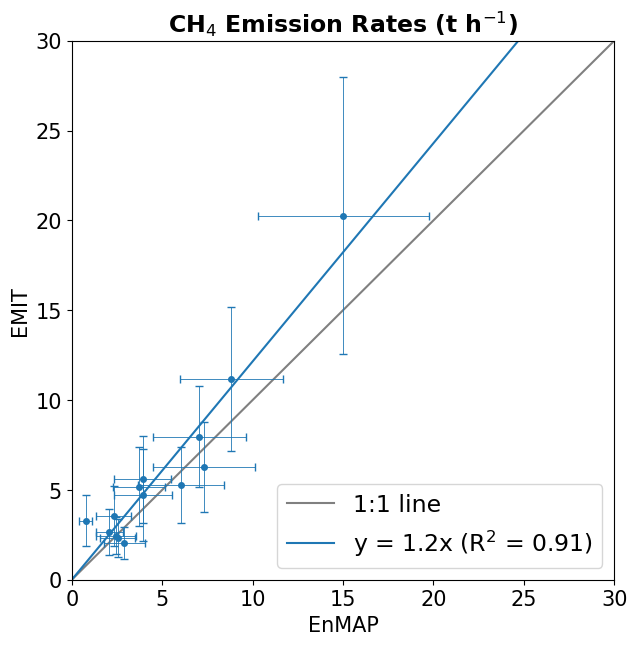

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))

enmap_row = df_emiss_twogrp[df_emiss_twogrp['platform']=='EnMAP']
x = enmap_row['emission'].values
xerr = enmap_row['emission_uncertainty']

emit_row = df_emiss_twogrp[df_emiss_twogrp['platform']=='EMIT']
y = emit_row['emission'].values
yerr = emit_row['emission_uncertainty']

# Reshape the arrays to 2D
x_2d = x.reshape(-1, 1)
y_2d = y.reshape(-1, 1)

# Create and fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(x_2d, y_2d)

# Get the slope of the linear regression line
slope = model.coef_[0][0]

# Calculate R-squared
r_squared = model.score(x_2d, y_2d)

plt.axline(xy1=(0, 0), slope=1, label=f'1:1 line',  c='gray')
plt.axline(xy1=(0, 0), slope=slope, label=f'y = {slope:.1f}x (R$^2$ = {r_squared:.2f})', c='C0')

ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', capsize=3, markersize=4, elinewidth=0.6)

ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_title('CH$_4$ Emission Rates (t h$^{-1}$)')
ax.set_xlabel('EnMAP')
ax.set_ylabel('EMIT')

plt.legend()

# fig.savefig('../figures/emit_enmap_fit.pdf')

## HSI observation numbers

In [7]:
# read the OBS file
df_obs = pd.read_excel('../data/landfills_hyper_obs.xlsx')

# remove space at end
df_obs['name'] = df_obs['name'].str.strip()

In [8]:
# tropomi hotspots with no observations of HSI (only consider EnMAP and EMIT)
# no_obs_mask = (df['source_tropomi']==1) & (df[['overpass(emit)', 'overpass(enmap)', 'overpass(prisma)']].sum(axis=1) == 0)
no_obs_mask = (df_obs['source_tropomi']==1) & (df_obs[['overpass(emit)', 'overpass(enmap)']].sum(axis=1) == 0)
obs_mask = ~no_obs_mask

# tropomi hotspots with no plume detected by HSI
no_plume_mask = (df_obs['source_tropomi']==1) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) == 0) & obs_mask

# plumes only detected by HSI 
hsi_plume_mask = (df_obs['source_tropomi']==0) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0) 

# tropomi hotspots with at least one plume detected by any HSI
both_plume_mask = (df_obs['source_tropomi']==1) & (df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0)

# plume mask
plume_mask = df_obs[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0

# hotspots mask
hotspots_mask = df_obs['source_tropomi'] == 1

In [9]:
# get the number of plume and clear overpasses for each HSI platform
df_emit_plume_obs = df_obs[plume_mask][['name', 'plume(emit)', 'overpass(emit)']].rename(columns={'plume(emit)': 'plume', 'overpass(emit)': 'overpass'})
df_enmap_plume_obs = df_obs[plume_mask][['name', 'plume(enmap)', 'overpass(enmap)']].rename(columns={'plume(enmap)': 'plume', 'overpass(enmap)': 'overpass'})
df_prisma_plume_obs = df_obs[plume_mask][['name', 'plume(prisma)', 'overpass(prisma)']].rename(columns={'plume(prisma)': 'plume', 'overpass(prisma)': 'overpass'})

# get the number of plume and clear overpasses of TROPOMI hotspots for each HSI platform
df_emit_hotspot_obs = df_obs[hotspots_mask][['name', 'plume(emit)', 'overpass(emit)']].rename(columns={'plume(emit)': 'plume', 'overpass(emit)': 'overpass'})
df_enmap_hotspot_obs = df_obs[hotspots_mask][['name', 'plume(enmap)', 'overpass(enmap)']].rename(columns={'plume(enmap)': 'plume', 'overpass(enmap)': 'overpass'})
df_prisma_hotspot_obs = df_obs[hotspots_mask][['name', 'plume(prisma)', 'overpass(prisma)']].rename(columns={'plume(prisma)': 'plume', 'overpass(prisma)': 'overpass'})

In [10]:
def get_stats_list(df):
    return [df[df['plume']>=1].__len__(), df[(df['plume']==0)&(df['overpass']>0)].__len__(), df[df['overpass']==0].__len__()]

def set_label_white(autotexts):
    for autotext in autotexts:
        autotext.set_color('white')

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d})"

def plot_pie(ax, data, colors=['#f3a26a', '#9f98de', 'silver']):
    # color: the color of pie patch
    #   order: >= 1, no plume, no OBS

    # get number > 0 part
    positive_index = np.nonzero(data)[0]
    data = [data[i] for i in positive_index]
    colors = [colors[i] for i in positive_index]

    patches, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                   textprops={'fontsize': 13, 'weight':'bold'}, colors=colors)
    set_label_white(autotexts)

    return patches

In [11]:
emit_plume_stats_list = get_stats_list(df_emit_plume_obs)
enmap_plume_stats_list = get_stats_list(df_enmap_plume_obs)
prisma_plume_stats_list = get_stats_list(df_prisma_plume_obs)

emit_hotspot_stats_list = get_stats_list(df_emit_hotspot_obs)
enmap_hotspot_stats_list = get_stats_list(df_enmap_hotspot_obs)
prisma_hotspot_stats_list = get_stats_list(df_prisma_hotspot_obs)

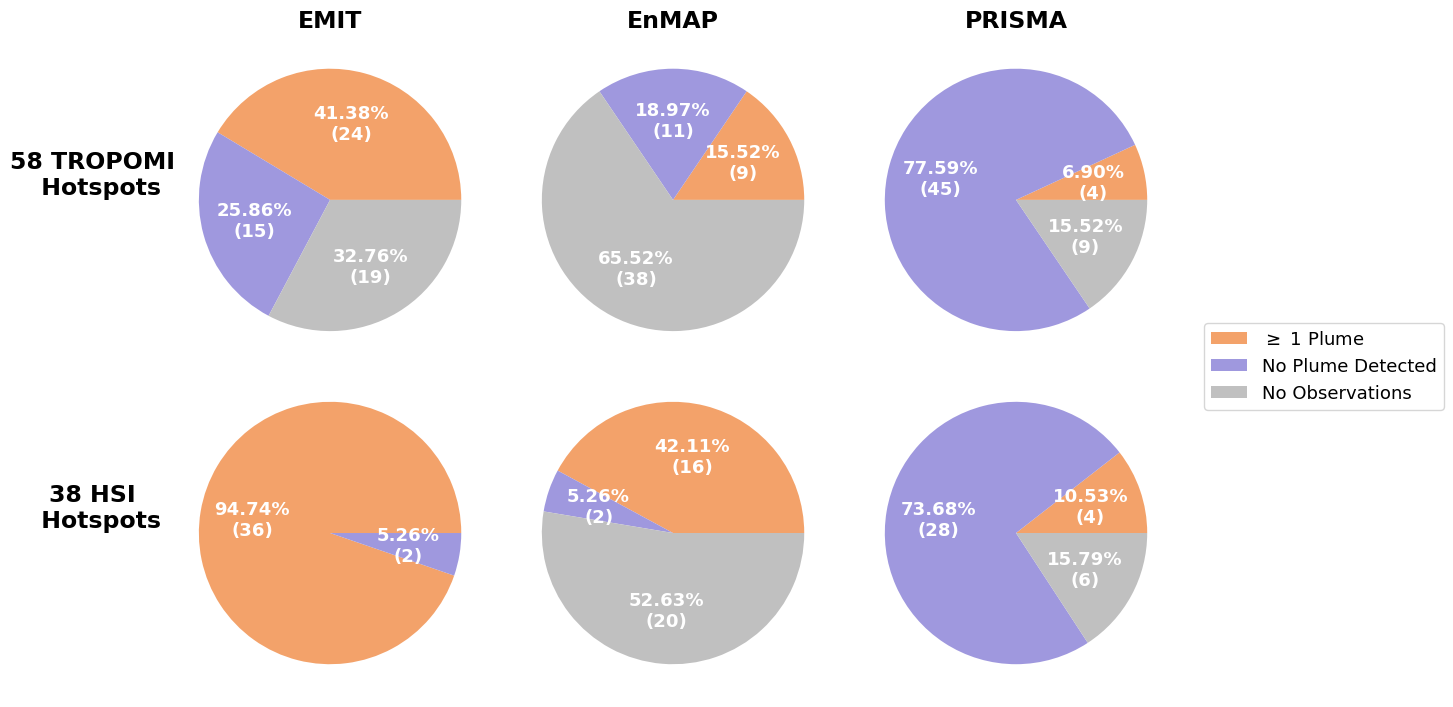

In [12]:
# pie data: plume >= 1, No Plume: plume=0, No OBS: overpass=0
legend_labels = ['$\geq$ 1 Plume', 'No Plume Detected', 'No Observations']
col_labels = ['EMIT', 'EnMAP', 'PRISMA']
row_labels = [f"{len(df_obs[df_obs['source_tropomi']==1])} TROPOMI \n Hotspots",
              f"{len(df_obs[plume_mask])} HSI \n Hotspots"]

# add row and column labels
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
for ax, col in zip(axs[0], col_labels):
    ax.set_title(col)

for ax, row in zip(axs[:,0], row_labels):
    ax.set_ylabel(row, rotation=0, size=font_size, fontweight='bold', labelpad=50)

axs = axs.flatten()

plot_pie(axs[0], emit_hotspot_stats_list)
plot_pie(axs[1], enmap_hotspot_stats_list)
plot_pie(axs[2], prisma_hotspot_stats_list)
plot_pie(axs[3], emit_plume_stats_list)
plot_pie(axs[4], enmap_plume_stats_list)
patches = plot_pie(axs[5], prisma_plume_stats_list)


fig.subplots_adjust(hspace=-0.7)

legend = fig.legend(patches, legend_labels,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 13}
          )

fig.tight_layout()
# fig.patch.set_facecolor('w')
# fig.patch.set_alpha(0)

fig.savefig('../figures/hsi_plume_stats.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')